In [8]:
import pandas as pd
import requests
from io import StringIO


url = "https://raw.githubusercontent.com/ladychb/ils_study/main/data/mixed/Study1a.tsv"
response = requests.get(url)
data = StringIO(response.text)
df = pd.read_csv(data, sep="\t")

df.columns

Index(['id', 'group', 'start time', 'end time', 'duration', 'pressed back',
       'attention check', 'age', 'gender', 'movie enthusiast', 'treatment',
       'movie order', 'movie familiarity', 'selection', 'diversity', 'variety',
       'similarity', 'easiness', 'confidence', 'amount', 'poster clicks',
       'decision time', 'logtime', 'ILS', 'inverse similarity',
       'Sum (div+var+invsim)'],
      dtype='object')

In [20]:
treatments = list(set(df['treatment']))
treatments

['Recommendation-based (low-ILS)',
 'Homogenous (minimize similarity of neighbors)',
 'Recommendation-based (high-ILS)',
 'Recommendation-based (mid-ILS minimize similarity of neighbors)',
 'Recommendation-based (mid-ILS maximize similarity of neighbors)',
 'Sequels',
 'Homogenous (shuffled)',
 'Homogenous (maximize similarity of neighbors)',
 'Recommendation-based (mid-ILS shuffled)']

In [46]:
def create_prompt(movie_order):
    prompt = 'Please rate this list of movies as a whole in terms of its diversity, in a scale from 1 to 5. We are thinking diversity on terms of genres, themes or overall variety, but not in terms of race or gender.\n\n'
    prompt += movie_order
    prompt += '\nFirst give your thoughts, and only then answer in the format "Diversity: {rating}"'
    return prompt

movie_order = 'Batman Begins. The Dark Knight. The Dark Knight Rises. Batman v Superman: Dawn of Justice. Batman Returns. Batman: The Dark Knight Returns. Part 1. Batman: The Dark Knight Returns. Part 2'
create_prompt(movie_order)

'Please rate this list of movies as a whole in terms of its diversity, in a scale from 1 to 5. We are thinking diversity on terms of genres, themes or overall variety, but not in terms of race or gender.\n\nBatman Begins. The Dark Knight. The Dark Knight Rises. Batman v Superman: Dawn of Justice. Batman Returns. Batman: The Dark Knight Returns. Part 1. Batman: The Dark Knight Returns. Part 2\nFirst give your thoughts, and only then answer in the format "Diversity: {rating}"'

In [32]:
import openai

openai.api_key = 'OPENAI-KEY'

In [47]:
data = {}

for treatment in treatments:
    movie_order = df[df['treatment'] == treatment].iloc[0]['movie order']
    prompt = create_prompt(movie_order)
    completion = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=[{"role": "user", "content": prompt}])
    response = completion.choices[0].message['content']
    data[treatment] = response
    print(movie_order)
    print(response)

2001: A Space Odyssey. Skyfall. Finding Nemo. Inside Out. Saw. The Lord of the Rings: The Return of the King. One Flew Over the Cuckoo's Nest
Thoughts: Looking at this list, there appears to be a decent variety of genres and themes represented. We have science fiction (2001: A Space Odyssey), espionage/action (Skyfall), animation/comedy (Finding Nemo, Inside Out), horror/thriller (Saw), epic fantasy (The Lord of the Rings: The Return of the King), and drama (One Flew Over the Cuckoo's Nest).

Diversity: 4
Pulp Fiction. Terminator 2: Judgment Day. Fight Club. The Godfather. Mad Max: Fury Road. Raiders of the Lost Ark. The Imitation Game
Thoughts:
Overall, this list of movies covers a range of genres and themes. It includes action, crime, science fiction, drama, and adventure films. The movies span various time periods and explore different storytelling styles. However, there is a tendency towards more intense and dark themes, with a focus on violence and conflict. 

Diversity: 3.5
The L

In [38]:
import re

def get_diversity_value(response):
    mat = re.search("Diversity: (\S*)", response)
    try:
        value = float(mat.groups()[0])
        return value
    except:
        print(response)
        return None



In [52]:
res = pd.DataFrame()
res['treatment'] = treatments
res

,treatment
0,Recommendation-based (low-ILS)
1,Homogenous (minimize similarity of neighbors)
2,Recommendation-based (high-ILS)
3,Recommendation-based (mid-ILS minimize similar...
4,Recommendation-based (mid-ILS maximize similar...
5,Sequels
6,Homogenous (shuffled)
7,Homogenous (maximize similarity of neighbors)
8,Recommendation-based (mid-ILS shuffled)


In [53]:
res['gpt-diversity'] = [get_diversity_value(value) for value in data.values()]
res

,treatment,gpt-diversity
0,Recommendation-based (low-ILS),4.0
1,Homogenous (minimize similarity of neighbors),3.5
2,Recommendation-based (high-ILS),3.0
3,Recommendation-based (mid-ILS minimize similar...,4.5
4,Recommendation-based (mid-ILS maximize similar...,4.5
5,Sequels,2.0
6,Homogenous (shuffled),3.5
7,Homogenous (maximize similarity of neighbors),3.5
8,Recommendation-based (mid-ILS shuffled),3.5


In [57]:
def set_ils(row):
    return df[df['treatment'] == row['treatment']].iloc[0]['ILS']

res['ils'] = res.apply(set_ils, axis=1)
res

treatment        Recommendation-based (low-ILS)
gpt-diversity                               4.0
Name: 0, dtype: object
treatment        Homogenous (minimize similarity of neighbors)
gpt-diversity                                              3.5
Name: 1, dtype: object
treatment        Recommendation-based (high-ILS)
gpt-diversity                                3.0
Name: 2, dtype: object
treatment        Recommendation-based (mid-ILS minimize similar...
gpt-diversity                                                  4.5
Name: 3, dtype: object
treatment        Recommendation-based (mid-ILS maximize similar...
gpt-diversity                                                  4.5
Name: 4, dtype: object
treatment        Sequels
gpt-diversity        2.0
Name: 5, dtype: object
treatment        Homogenous (shuffled)
gpt-diversity                      3.5
Name: 6, dtype: object
treatment        Homogenous (maximize similarity of neighbors)
gpt-diversity                                              3

,treatment,gpt-diversity,ils
0,Recommendation-based (low-ILS),4.0,0.36510
1,Homogenous (minimize similarity of neighbors),3.5,0.40900
2,Recommendation-based (high-ILS),3.0,0.46435
3,Recommendation-based (mid-ILS minimize similar...,4.5,0.41330
4,Recommendation-based (mid-ILS maximize similar...,4.5,0.41330
5,Sequels,2.0,0.50800
6,Homogenous (shuffled),3.5,0.40900
7,Homogenous (maximize similarity of neighbors),3.5,0.40900
8,Recommendation-based (mid-ILS shuffled),3.5,0.41330


In [71]:
import numpy as np

def set_human_response(row):
    return np.average(df[df['treatment'] == row['treatment']]['Sum (div+var+invsim)'])

res['human'] = res.apply(set_human_response, axis=1)
res

,treatment,gpt-diversity,ils,human
0,Recommendation-based (low-ILS),4.0,0.36510,12.222222
1,Homogenous (minimize similarity of neighbors),3.5,0.40900,10.460526
2,Recommendation-based (high-ILS),3.0,0.46435,8.723684
3,Recommendation-based (mid-ILS minimize similar...,4.5,0.41330,10.985294
4,Recommendation-based (mid-ILS maximize similar...,4.5,0.41330,11.407407
5,Sequels,2.0,0.50800,6.546667
6,Homogenous (shuffled),3.5,0.40900,10.521127
7,Homogenous (maximize similarity of neighbors),3.5,0.40900,10.671053
8,Recommendation-based (mid-ILS shuffled),3.5,0.41330,11.310811


In [62]:
res.sort_values(by='human')

,treatment,gpt-diversity,ils,human
5,Sequels,2.0,0.50800,2.373333
2,Recommendation-based (high-ILS),3.0,0.46435,3.171053
1,Homogenous (minimize similarity of neighbors),3.5,0.40900,3.750000
7,Homogenous (maximize similarity of neighbors),3.5,0.40900,3.763158
6,Homogenous (shuffled),3.5,0.40900,3.859155
3,Recommendation-based (mid-ILS minimize similar...,4.5,0.41330,3.941176
4,Recommendation-based (mid-ILS maximize similar...,4.5,0.41330,4.086420
8,Recommendation-based (mid-ILS shuffled),3.5,0.41330,4.121622
0,Recommendation-based (low-ILS),4.0,0.36510,4.222222


In [74]:
url = "https://raw.githubusercontent.com/ladychb/ils_study/main/data/mixed/Study1b.tsv"
response = requests.get(url)
data = StringIO(response.text)
df = pd.read_csv(data, sep="\t")

df.columns

Index(['id', 'group', 'start time', 'end time', 'duration', 'pressed back',
       'attention check', 'age', 'gender', 'cooking enthusiast',
       'restrictions', 'treatment', 'order', 'familiarity', 'selection',
       'diversity', 'variety', 'similarity', 'easiness', 'confidence',
       'amount', 'poster clicks', 'decision time', 'logtime', 'ILS',
       'Sum (div+var+invsim)', 'inverse similarity'],
      dtype='object')

In [75]:
treatments = list(set(df['treatment']))
treatments

['Recommendation-based (low-ILS)',
 'Homogenous (minimize similarity of neighbors)',
 'Recommendation-based (high-ILS)',
 'Recommendation-based (mid-ILS minimize similarity of neighbors)',
 'Collection',
 'Recommendation-based (mid-ILS maximize similarity of neighbors)',
 'Homogenous (shuffled)',
 'Homogenous (maximize similarity of neighbors)',
 'Recommendation-based (mid-ILS shuffled)']

In [76]:
def create_prompt(movie_order):
    prompt = 'Please rate this list of recipies as a whole in terms of its diversity, in a scale from 1 to 5. We are thinking diversity on terms of flavours, styles or overall variety.\n\n'
    prompt += movie_order
    prompt += '\nFirst give your thoughts, and only then answer in the format "Diversity: {rating}"'
    return prompt

movie_order = 'Batman Begins. The Dark Knight. The Dark Knight Rises. Batman v Superman: Dawn of Justice. Batman Returns. Batman: The Dark Knight Returns. Part 1. Batman: The Dark Knight Returns. Part 2'
create_prompt(movie_order)

'Please rate this list of recipies as a whole in terms of its diversity, in a scale from 1 to 5. We are thinking diversity on terms of flavours, styles or overall variety.\n\nBatman Begins. The Dark Knight. The Dark Knight Rises. Batman v Superman: Dawn of Justice. Batman Returns. Batman: The Dark Knight Returns. Part 1. Batman: The Dark Knight Returns. Part 2\nFirst give your thoughts, and only then answer in the format "Diversity: {rating}"'

In [77]:
data = {}

for treatment in treatments:
    movie_order = df[df['treatment'] == treatment].iloc[0]['order']
    prompt = create_prompt(movie_order)
    completion = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=[{"role": "user", "content": prompt}])
    response = completion.choices[0].message['content']
    data[treatment] = response
    print(movie_order)
    print(response)

Jays Signature Pizza Crust", Broiled Tilapia Parmesan, Delicious Ham and Potato Soup, Baked Teriyaki Chicken, Award Winning Soft Chocolate Chip Cookies, Slow Cooker Mashed Potatoes, Mexican Rice
Thoughts: This list of recipes seems to offer a decent range of flavors and styles. It includes dishes from different cuisines such as Italian (pizza crust), Asian (teriyaki chicken), Mexican (Mexican rice), and American (chocolate chip cookies). There is a mix of main dishes, side dishes, and desserts, which adds to the overall variety.

Diversity: 4
Lentil Stew, Tandoori Chicken, Black Bean, Sausage, and Sweet Potato Soup, BBQ Chicken Wings, Easy Sweet ChiliAunt Ros Baked Beans"Chicken Penne with Asparagus
Thoughts: This list of recipes covers a range of different flavors, styles, and ingredients. It includes dishes from various cuisines such as Indian, American, and Italian. However, it does lack a bit in terms of vegetarian or vegan options and certain ethnic cuisines.

Diversity: 4
Beths S

In [78]:
res = pd.DataFrame()
res['treatment'] = treatments
res

,treatment
0,Recommendation-based (low-ILS)
1,Homogenous (minimize similarity of neighbors)
2,Recommendation-based (high-ILS)
3,Recommendation-based (mid-ILS minimize similar...
4,Collection
5,Recommendation-based (mid-ILS maximize similar...
6,Homogenous (shuffled)
7,Homogenous (maximize similarity of neighbors)
8,Recommendation-based (mid-ILS shuffled)


In [79]:
res['gpt-diversity'] = [get_diversity_value(value) for value in data.values()]
res

,treatment,gpt-diversity
0,Recommendation-based (low-ILS),4.0
1,Homogenous (minimize similarity of neighbors),4.0
2,Recommendation-based (high-ILS),3.5
3,Recommendation-based (mid-ILS minimize similar...,4.0
4,Collection,2.0
5,Recommendation-based (mid-ILS maximize similar...,3.5
6,Homogenous (shuffled),3.5
7,Homogenous (maximize similarity of neighbors),4.0
8,Recommendation-based (mid-ILS shuffled),3.0


In [80]:
def set_ils(row):
    return df[df['treatment'] == row['treatment']].iloc[0]['ILS']

res['ils'] = res.apply(set_ils, axis=1)
res

,treatment,gpt-diversity,ils
0,Recommendation-based (low-ILS),4.0,0.38
1,Homogenous (minimize similarity of neighbors),4.0,0.35
2,Recommendation-based (high-ILS),3.5,0.44
3,Recommendation-based (mid-ILS minimize similar...,4.0,0.41
4,Collection,2.0,0.48
5,Recommendation-based (mid-ILS maximize similar...,3.5,0.41
6,Homogenous (shuffled),3.5,0.35
7,Homogenous (maximize similarity of neighbors),4.0,0.35
8,Recommendation-based (mid-ILS shuffled),3.0,0.41


In [81]:
import numpy as np

def set_human_response(row):
    return np.average(df[df['treatment'] == row['treatment']]['diversity'])

res['human'] = res.apply(set_human_response, axis=1)
res

,treatment,gpt-diversity,ils,human
0,Recommendation-based (low-ILS),4.0,0.38,4.314286
1,Homogenous (minimize similarity of neighbors),4.0,0.35,3.917808
2,Recommendation-based (high-ILS),3.5,0.44,4.220588
3,Recommendation-based (mid-ILS minimize similar...,4.0,0.41,4.158730
4,Collection,2.0,0.48,2.370968
5,Recommendation-based (mid-ILS maximize similar...,3.5,0.41,4.054795
6,Homogenous (shuffled),3.5,0.35,3.800000
7,Homogenous (maximize similarity of neighbors),4.0,0.35,3.741935
8,Recommendation-based (mid-ILS shuffled),3.0,0.41,4.156250


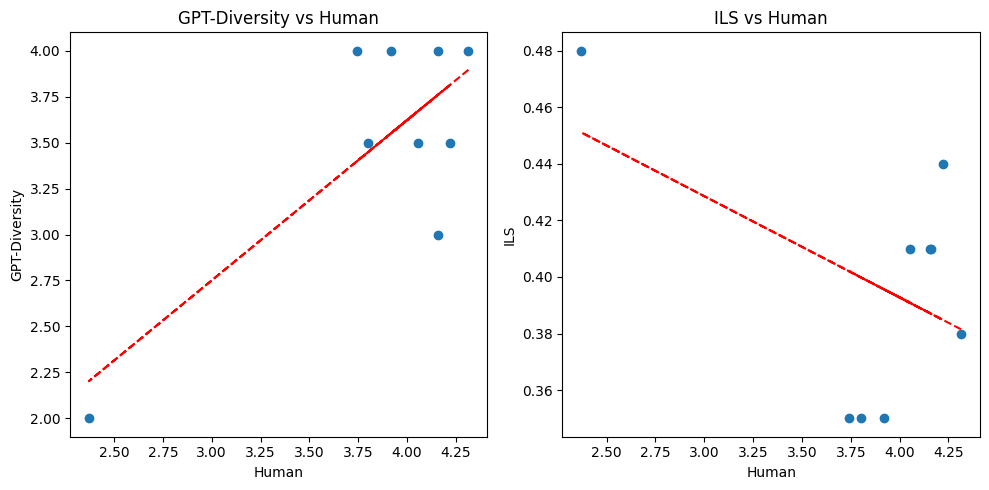

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot for 'gpt-diversity' vs 'human'
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(res['human'], res['gpt-diversity'])
plt.title('GPT-Diversity vs Human')
plt.xlabel('Human')
plt.ylabel('GPT-Diversity')

# Adding linear regression line
m, b = np.polyfit(res['human'], res['gpt-diversity'], 1)
plt.plot(res['human'], m*res['human'] + b, 'r--')

# Scatter plot for 'ils' vs 'human'
plt.subplot(1, 2, 2)
plt.scatter(res['human'], res['ils'])
plt.title('ILS vs Human')
plt.xlabel('Human')
plt.ylabel('ILS')

# Adding linear regression line
m, b = np.polyfit(res['human'], res['ils'], 1)
plt.plot(res['human'], m*res['human'] + b, 'r--')

plt.tight_layout()
plt.savefig('recipies-difference-human.png')
plt.show()


In [83]:
import statsmodels.api as sm

# Assuming 'res' is your DataFrame

# Adding a constant term for intercept
X = sm.add_constant(res[['gpt-diversity', 'ils']])
y = res['human']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary statistics
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  human   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     5.303
Date:                Thu, 02 Nov 2023   Prob (F-statistic):             0.0472
Time:                        13:03:10   Log-Likelihood:                -2.9184
No. Observations:                   9   AIC:                             11.84
Df Residuals:                       6   BIC:                             12.43
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.6812      2.956     -0.230

/Users/tomasvergara/miniconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
